In [47]:
# imports

# external modules
import sys
import os
import numpy as np
import pandas as pd
import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import importlib
# framework modules
sys.path.append('../')
import plotting.plottools
importlib.reload(plotting.plottools)
from plotting.plottools import plot_histogram
import training.prepare_training_set
importlib.reload(training.prepare_training_set)
from training.prepare_training_set import prepare_training_data_from_files
# local modules
import fake_anomaly
importlib.reload(fake_anomaly)

<module 'fake_anomaly' from '/eos/home-i00/l/llambrec/pixelae/evaluation/fake_anomaly.py'>

In [48]:
# load the training set

files = ([
    '../data/data/ZeroBias-Run2023C-PromptReco-v1-DQMIO-PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1_preprocessed.parquet',
    #'../data/data/ZeroBias-Run2023C-PromptReco-v2-DQMIO-PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1_preprocessed.parquet',
    #'../data/data/ZeroBias-Run2023C-PromptReco-v3-DQMIO-PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1_preprocessed.parquet',
    #'../data/data/ZeroBias-Run2023C-PromptReco-v4-DQMIO-PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1_preprocessed.parquet',
    #'../data/data/ZeroBias-Run2023D-PromptReco-v1-DQMIO-PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1_preprocessed.parquet',
    #'../data/data/ZeroBias-Run2023D-PromptReco-v2-DQMIO-PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1_preprocessed.parquet',
])
kwargs = ({
    'verbose': True,
    'entries_threshold': 10000,
    'skip_first_lumisections': 5
})
(training_data, training_runs, training_lumis) = prepare_training_data_from_files(files, **kwargs)

Loading file ../data/data/ZeroBias-Run2023C-PromptReco-v1-DQMIO-PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1_preprocessed.parquet
  Shape of hists array: (18065, 32, 32)
  Runs: [367094 367094 367094 ... 367515 367515 367515]
  Lumis: [  1   2   3 ... 666 667 668]
  Entries: [    0     0     0 ... 69383 67139 23294]
  Passing number of entries: 16503 (91.35 %)
  Passing lumisection skip: 17794 (98.50 %)
  Training lumisections: 16359 (90.56 %)
Shape of training data: (16359, 32, 32, 1)
Shape of training runs: (16359,)
Shape of training lumis: (16359,)


In [49]:
# load keras model

modelname = '../models/model_20231115_Run2023C-v1_PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1.keras'
model = keras.models.load_model(modelname)

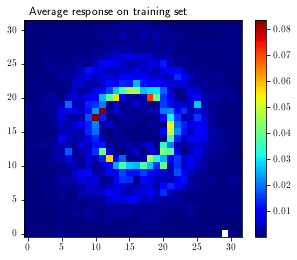

In [50]:
# load average response on training set

avgresponsename = '../models/model_20231115_Run2023C-v1_PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1_avgresponse.npy'
avgresponse = np.load(avgresponsename)
fig,ax = plt.subplots()
plot_histogram(avgresponse, fig=fig, ax=ax)
ax.text(0.02, 1.02, 'Average response on training set', transform=ax.transAxes, fontsize=12)
avgresponse[avgresponse==0] = 1
avgresponse = np.expand_dims(avgresponse, axis=2)

In [51]:
# make a mask where values are always zero

shape_mask = (np.sum(training_data, axis=0)==0)[:,:,0]

In [52]:
# make a collection of fake anomalies

nanomalies = 100
random_indices = np.random.choice(len(training_data), size=nanomalies, replace=False)

anomalies = np.zeros((nanomalies, training_data.shape[1], training_data.shape[2], 1))
params = []
for newidx,origidx in enumerate(random_indices):
    hist = training_data[origidx,:,:,0]
    (anomalous_hist, paramdict) = fake_anomaly.dead_rectangle(hist, shape_mask=~shape_mask)
    #(anomalous_hist, paramdict) = fake_anomaly.dead_sector(hist)
    #(anomalous_hist, paramdict) = fake_anomaly.hot_rectangle(hist, shape_mask=~shape_mask)
    #(anomalous_hist, paramdict) = fake_anomaly.hot_sector(hist)
    anomalies[newidx,:,:,0] = anomalous_hist
    params.append(paramdict)

In [53]:
# evaluate the model

predictions = model.predict(training_data)
predictions[predictions<0] = 0.
predictions[:,shape_mask] = 0.

predictions_anomalies = model.predict(anomalies)
predictions_anomalies[predictions_anomalies<0] = 0.
predictions_anomalies[:,shape_mask] = 0.

4/4 [==============================] - 0s 11ms/step


In [54]:
# calculate squared difference

errors = np.square(training_data - predictions)
errors_anomalies = np.square(anomalies - predictions_anomalies)

# space correction
errors_corrected = errors/avgresponse
errors_anomalies_corrected = errors_anomalies/avgresponse

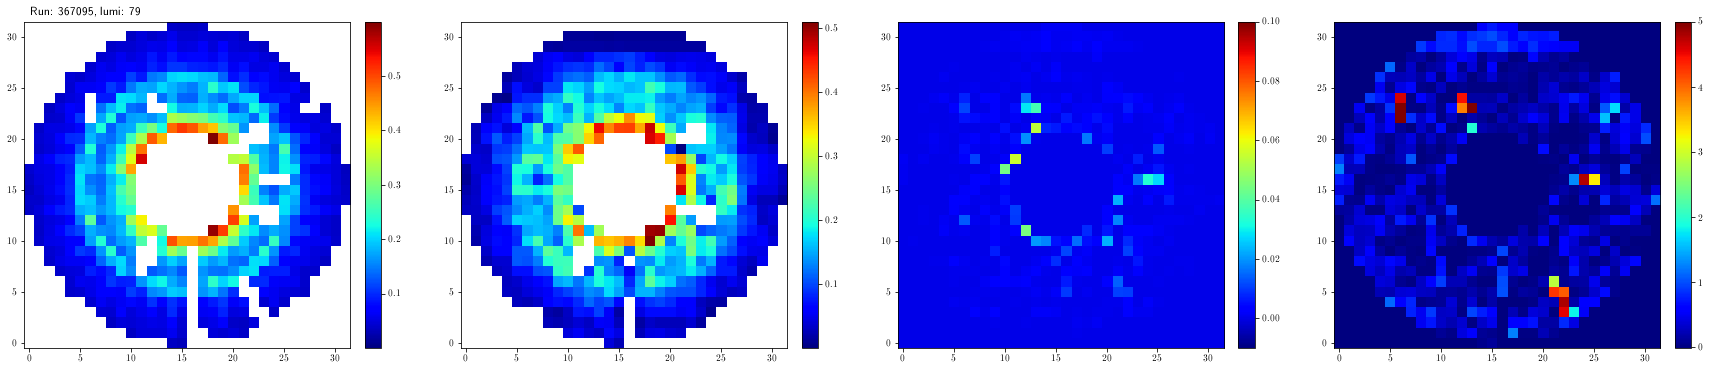

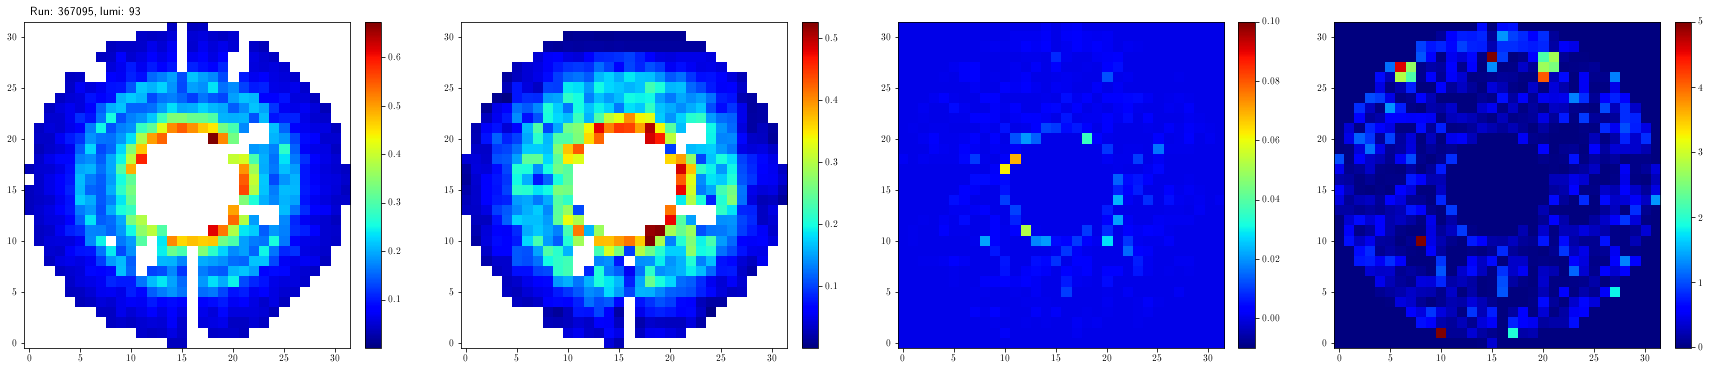

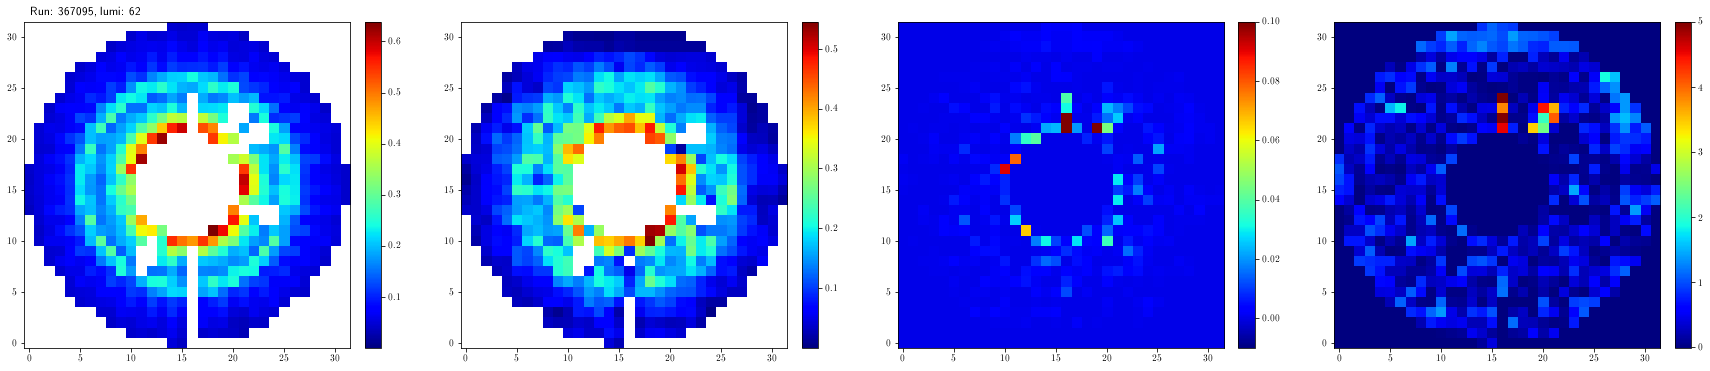

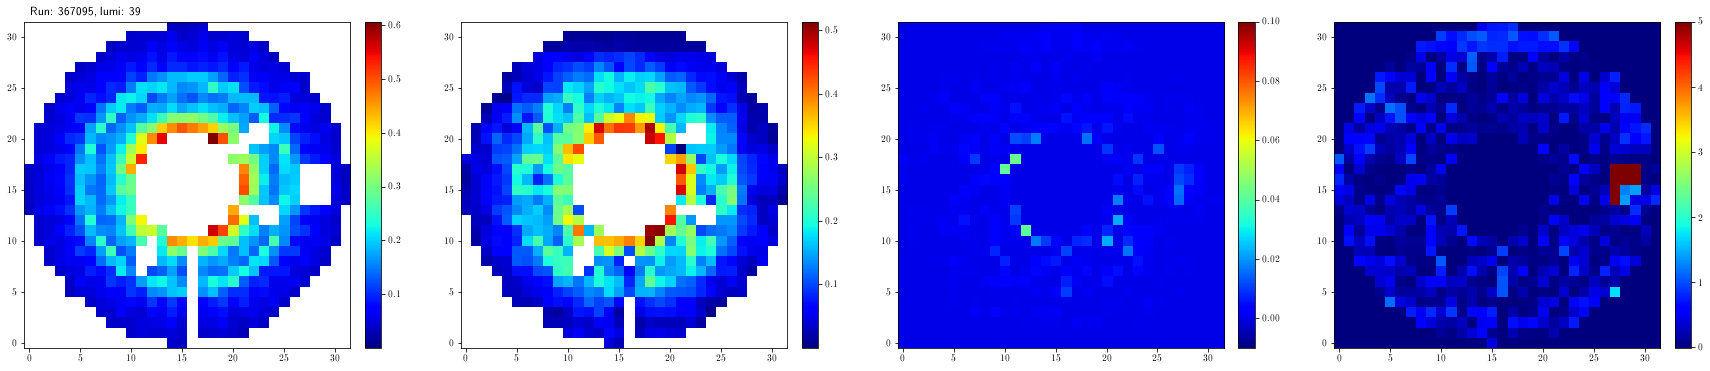

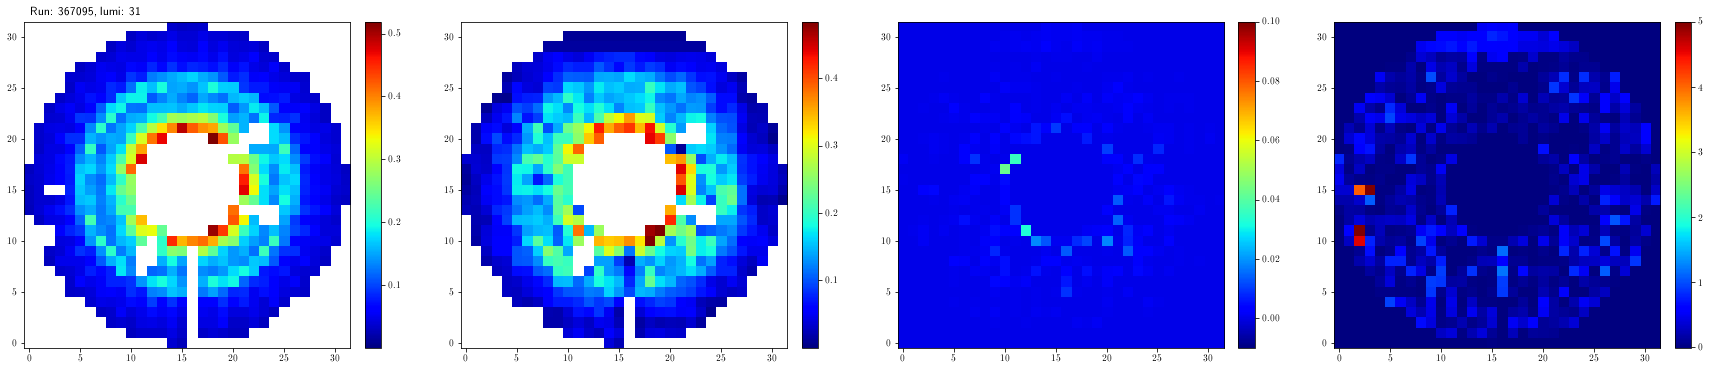

In [55]:
# make plots

nplots = 5
plotids = np.random.choice(len(anomalies), size=nplots, replace=False)

for i in plotids:
    fig,axs = plt.subplots(figsize=(30,6), ncols=4)
    plot_histogram(anomalies[i,:,:,0], fig=fig, ax=axs[0])
    plot_histogram(predictions_anomalies[i,:,:,0], fig=fig, ax=axs[1])
    plot_histogram(errors_anomalies[i,:,:,0], fig=fig, ax=axs[2], caxrange=(-0.01, 0.1))
    plot_histogram(errors_anomalies_corrected[i,:,:,0], fig=fig, ax=axs[3], caxrange=(-0.01, 5.))
    axs[0].text(0.02, 1.02, 'Run: {}, lumi: {}'.format(training_runs[i], training_lumis[i]), transform=axs[0].transAxes, fontsize=12)